Successfully loaded 'PlayStation Sales and Metadata... .csv'

Dropped 3433 rows with missing data.

Task: Predict 'metacritic' using ['rating', 'ratings_count', 'Total Sales']
Total samples for modeling: 1530

Training samples: 1224
Test samples:     306

Training Linear, Ridge (L2), and Lasso (L1) models...
--- Model Performance Comparison ---
Model        | R-squared (R²)  | RMSE      
----------------------------------------
Linear       | 0.4083          | 9.1623    
Ridge (L2)   | 0.4082          | 9.1626    
Lasso (L1)   | 0.3893          | 9.3083    
------------------------------------

Generating graphical analysis of feature coefficients...


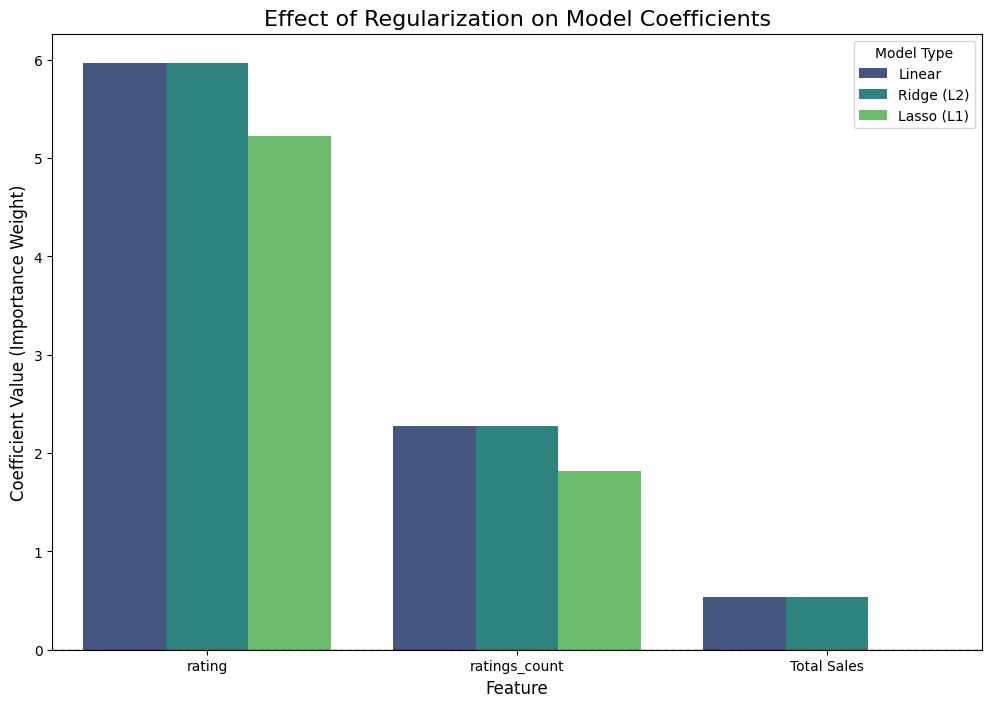


--- Coefficient Analysis ---
Model          Lasso (L1)  Linear  Ridge (L2)
Feature                                      
Total Sales        0.0000  0.5373      0.5378
rating             5.2206  5.9680      5.9632
ratings_count      1.8123  2.2752      2.2747

Analysis complete. Check the bar plot to see the regularization effect.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

def run_regularized_regression():
    """
    Loads PlayStation sales data, trains and compares Linear, Ridge,
    and Lasso regression models to predict 'metacritic' scores.
    """

    # --------------------------
    # 1. Load and Prepare Data
    # --------------------------
    try:
        df = pd.read_csv("PlayStation Sales and Metadata (PS3PS4PS5) (Oct 2025).csv")
        print("Successfully loaded 'PlayStation Sales and Metadata... .csv'\n")
    except FileNotFoundError:
        print("Error: 'PlayStation Sales and Metadata (PS3PS4PS5) (Oct 2025).csv' not found.")
        print("Please make sure the file is in the same directory as the script.")
        return

    # Define the regression task:
    # Predict 'metacritic' (y) using these numerical features (X).
    features_list = ['rating', 'ratings_count', 'Total Sales']
    target = 'metacritic'

    # Clean the data: drop rows where our target or features are missing
    all_cols = features_list + [target]
    original_count = len(df)
    df.dropna(subset=all_cols, inplace=True)
    # Also, Metacritic score of 0 is likely missing data, so let's remove it.
    df = df[df['metacritic'] > 0]

    X = df[features_list]
    y = df[target]

    print(f"Dropped {original_count - len(df)} rows with missing data.")
    print(f"\nTask: Predict '{target}' using {features_list}")
    print(f"Total samples for modeling: {len(y)}\n")

    # --------------------------
    # 2. Split and Scale Data
    # --------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scaling is CRUCIAL for regularized regression, so all
    # features are on the same scale (mean 0, variance 1).
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training samples: {len(X_train)}")
    print(f"Test samples:     {len(X_test)}\n")

    # --------------------------
    # 3. Train Models
    # --------------------------
    print("Training Linear, Ridge (L2), and Lasso (L1) models...")

    # We will use alpha=1.0 for this comparison.
    # 'alpha' is the hyperparameter that controls the strength of regularization.

    # Model 1: Standard Linear Regression (Baseline)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # Model 2: Ridge Regression (L2 Regularization)
    ridge_reg = Ridge(alpha=1.0)
    ridge_reg.fit(X_train_scaled, y_train)

    # Model 3: Lasso Regression (L1 Regularization)
    lasso_reg = Lasso(alpha=1.0)
    lasso_reg.fit(X_train_scaled, y_train)

    # --------------------------
    # 4. Evaluate Model Performance
    # --------------------------
    models = {
        "Linear": lin_reg,
        "Ridge (L2)": ridge_reg,
        "Lasso (L1)": lasso_reg
    }

    results = {}

    print("--- Model Performance Comparison ---")
    print(f"{'Model':<12} | {'R-squared (R²)':<15} | {'RMSE':<10}")
    print("-" * 40)

    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = {'R²': r2, 'RMSE': rmse, 'coef': model.coef_}
        print(f"{name:<12} | {r2:<15.4f} | {rmse:<10.4f}")

    print("------------------------------------\n")

    # --------------------------
    # 5. Analyze and Visualize Regularization Effect
    # --------------------------
    print("Generating graphical analysis of feature coefficients...")

    # We will create a DataFrame to compare the coefficients (weights)
    # assigned to each feature by each model.
    coef_data = []
    for name, result_data in results.items():
        for feature, coef in zip(features_list, result_data['coef']):
            coef_data.append({'Model': name, 'Feature': feature, 'Coefficient': coef})

    coef_df = pd.DataFrame(coef_data)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=coef_df,
        x='Feature',
        y='Coefficient',
        hue='Model',
        palette='viridis'
    )
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title('Effect of Regularization on Model Coefficients', fontsize=16)
    plt.ylabel('Coefficient Value (Importance Weight)', fontsize=12)
    plt.xlabel('Feature', fontsize=12)
    plt.legend(title='Model Type')
    plt.show()

    print("\n--- Coefficient Analysis ---")
    print(coef_df.pivot(index='Feature', columns='Model', values='Coefficient').round(4))
    print("\nAnalysis complete. Check the bar plot to see the regularization effect.")

if __name__ == "__main__":
    run_regularized_regression()